# SMS Chat Analysis 
***


## Goals

The goal of this project is to experiment with various NLP methods on an SMS Text dataset and gather informative insights.

## Data

The National University of Singapore SMS Corpus dataset, made publicly available by The National University of Singapore.  This corpus was collected by Tao Chen and Min-Yen Kan.

* **id:**  Unique identifier for each message.<br>
* **Message:**	   The message contents.<br>
* **length:**	   Total number of characters in the message.<br>
* **country:**	   Country the sender is from.<br>
* **Date:**	    Month and Year a message was sent.<br>

## Questions 

- What is the overall sentiment of the text message as well as broken down by country?
- What are the most common topics/words?
- What are the most common words used by sentiment?


#### Importing libraries

In [2]:
#Importing libraries    
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from sklearn import svm
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, WordNetLemmatizer, pos_tag, RegexpParser 
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter

In [3]:
pd.options.display.max_colwidth = 60
%matplotlib inline

#### Importing data

In [4]:
#Importing data
data = pd.read_csv('clean_nus_sms.csv')
data.head()


,Unnamed: 0,id,Message,length,country,Date
0,0,10120,Bugis oso near wat...,21,SG,2003/4
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4
4,4,10124,Meet after lunch la...,22,SG,2003/4


The dataset has 48,598 rows and 6 columns

In [5]:
#Data shape
data.shape

(48598, 6)

The dataset has 39,463 unique message ids

In [6]:
#Data unique id
data.id.nunique()

39463

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48598 entries, 0 to 48597
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  48598 non-null  int64 
 1   id          48598 non-null  int64 
 2   Message     48595 non-null  object
 3   length      48598 non-null  object
 4   country     48598 non-null  object
 5   Date        48598 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.2+ MB


### Data Cleaning and Noise Removal

There are 3 blank messages.  We will drop these rows.

In [8]:
data = data.dropna()

Filtering the dataset for messages that contain more than 1 character

In [9]:
#filter dataframe for Message with more than 1 character
data = data[data['Message'].str.len() > 1]
data.shape

(48559, 6)

Creating a new column to contain 'cleaned' messages.  Converting all strings to lowercase.

In [10]:
data['message_cleaned'] = data.Message.str.lower()

In [11]:
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat...
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,"go until jurong point, crazy.. available only in bugis n..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when... lets go learn pilates...
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price... haiz... cant eat ...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la...


Removing all punctuations from message_cleaned

In [12]:
#create a function to remove punctuations
def remove_punct(txt):
    return re.sub(r'[^\w\s]', '', txt)

data['message_cleaned'] = data['message_cleaned'].apply(lambda x: remove_punct(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la


Removing urls from messages

In [13]:
#create a function to remove urls
def remove_url(txt):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',txt)

In [14]:
#Removing urls
data['message_cleaned'] = data['message_cleaned'].apply(lambda x: remove_url(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la


In [15]:
#create a function to remove muliple periods 
# def remove_periods(txt):
#     return re.sub(r'\.{2,}', '', txt)

Tokenize messages and create new column 'message_tokenized'

In [16]:
#create a function to tokenize messages 
def tokenize(txt):
    tokens = word_tokenize(txt)
    return tokens

In [17]:
pd.set_option('display.max_columns', None)
#Tokenizing messages
data['message_tokenized'] = data['message_cleaned'].apply(lambda x: tokenize(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat,"[bugis, oso, near, wat]"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e..."
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la,"[meet, after, lunch, la]"


Lemmatize messages and create new column

In [18]:
#Lemmatize messages
lemmatizer = WordNetLemmatizer()
data['message_lemmatized'] = data.message_tokenized.apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea..."
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]"


In [19]:
#create function to remove stop words  
stop_words = set(stopwords.words('english'))   
def remove_stopwords(txt):
    return [word for word in txt if word not in stop_words]

#create function to remove numbers 
def remove_numbers(txt):
    return [word for word in txt if not word.isdigit()]

#apply functions
data['message_lemmatized_nostop'] = data.message_lemmatized.apply(lambda x: remove_stopwords(x))
data['message_lemmatized_nostop'] = data.message_lemmatized_nostop.apply(lambda x: remove_numbers(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop
0,0,10120,Bugis oso near wat...,21,SG,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,SG,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,SG,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,SG,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia..."
4,4,10124,Meet after lunch la...,22,SG,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]"


View number of messages per country.  

In [20]:
#view number of messages per country
data.country.value_counts()

country
Singapore              22010
SG                      9794
India                   6886
United States           3746
USA                     1931
Sri Lanka               1017
Malaysia                 766
Pakistan                 746
unknown                  602
Canada                   198
Bangladesh               126
China                    107
india                    105
INDIA                     79
Philippines               67
Indonesia                 48
Nepal                     39
srilanka                  30
United Kingdom            30
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Turkey                    10
Trinidad and Tobago       10
Lebanon                   10
Slovenia                  10
Nigeria                   10
New Zealand               10
Macedonia                 10
UK                        10
Morocco                    9
Romania                    9
Austra

Rename countries to clean up duplicates

In [21]:
#clean country names
data = data.replace({'country': {'USA': 'United States', 
                                 'SG': 'Singapore', 
                                 'india': 'India', 
                                 'sri lanka': 'Sri Lanka', 
                                 'INDIA': 'India',
                                 'pakistan': 'Pakistan',
                                 'UK': 'United Kingdom',
                                 'jamaica': 'Jamaica',
                                 'MY': 'Malaysia',
                                 'srilanka': 'Sri Lanka',}})
data.country.value_counts()

country
Singapore              31804
India                   7070
United States           5677
Sri Lanka               1047
Malaysia                 767
Pakistan                 746
unknown                  602
Canada                   198
Bangladesh               126
China                    107
Philippines               67
Indonesia                 48
United Kingdom            40
Nepal                     39
Hungary                   28
Serbia                    22
Kenya                     20
Ghana                     18
Italia                    10
Trinidad and Tobago       10
Lebanon                   10
Turkey                    10
Nigeria                   10
New Zealand               10
Slovenia                  10
Macedonia                 10
Morocco                    9
Australia                  9
Romania                    9
Jamaica                    8
BARBADOS                   8
Spain                      5
France                     5
Name: count, dtype: int64

There are 33 unique countries in this dataset and the vast majority of messages are from Singapore, followed by India and the United States

In [22]:
#count the number of unique countries
data.country.nunique()

33

## Analyze

Visualize the number of messages sent per country

Text(0.5, 0, 'Number of Messages')

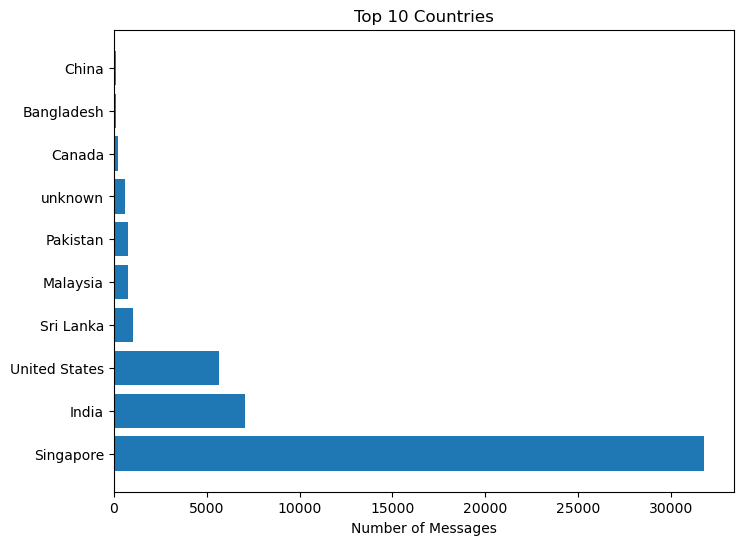

In [23]:
#create dataframe of number of messages per country
country_messages = data.country.value_counts().reset_index()

top_10 = country_messages.head(10)
top_10
#plot top 10 countries
plt.figure(figsize=(8, 6))
plt.barh(top_10['country'], top_10['count'])
plt.title('Top 10 Countries')
plt.xlabel('Number of Messages')

Create a wordcloud from the 'cleaned' messages to visualize the most common words used.  The most frequent terms appear to be: 'haha', 'u', 'ok', 'lol', 'one', 'time', 'going', 'hey', 'got', 'today' and 'think'.

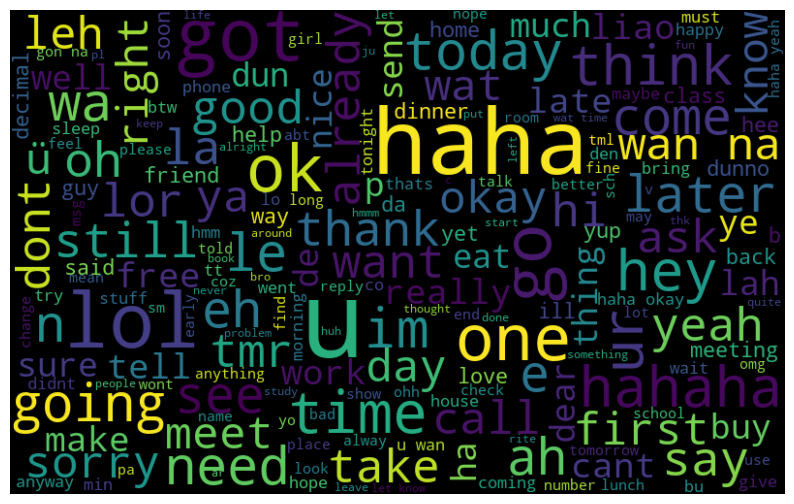

In [24]:
#create wordcloud from message_lemmatized_nostop
all_words = ' '.join([' '.join(text) for text in data['message_lemmatized_nostop']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Creating a frequency distribution of the top words used

In [25]:
#create frequency distribution of words
all_words_list = all_words.split(' ')
fdist = FreqDist(all_words_list)
fdist.most_common(20)

[('u', 10345),
 ('haha', 6514),
 ('go', 3349),
 ('lol', 2996),
 ('got', 2585),
 ('im', 2328),
 ('ok', 2265),
 ('time', 2072),
 ('okay', 1693),
 ('hahaha', 1665),
 ('ur', 1661),
 ('le', 1571),
 ('one', 1560),
 ('going', 1541),
 ('oh', 1467),
 ('hey', 1459),
 ('like', 1431),
 ('come', 1420),
 ('think', 1417),
 ('get', 1409)]

Tagging all words with Parts of Speech to gain further insights

In [26]:
#find most common topics using pos tagging
all_words_list = all_words.split(' ')
pos_tagged = pos_tag(all_words_list)
pos_tagged[:10]


[('bugis', 'NN'),
 ('oso', 'NN'),
 ('near', 'IN'),
 ('wat', 'NN'),
 ('go', 'VBP'),
 ('jurong', 'JJ'),
 ('point', 'NN'),
 ('crazy', 'NN'),
 ('available', 'JJ'),
 ('bugis', 'NN')]

Extracting nouns to a separate list

In [27]:
#extract nouns
nouns = [word for word, pos in pos_tagged if pos == 'NN']
nouns[:10]

['bugis',
 'oso',
 'wat',
 'point',
 'crazy',
 'bugis',
 'world',
 'la',
 'cine',
 'dunno']

Creating a wordcloud to visualize the most common nouns

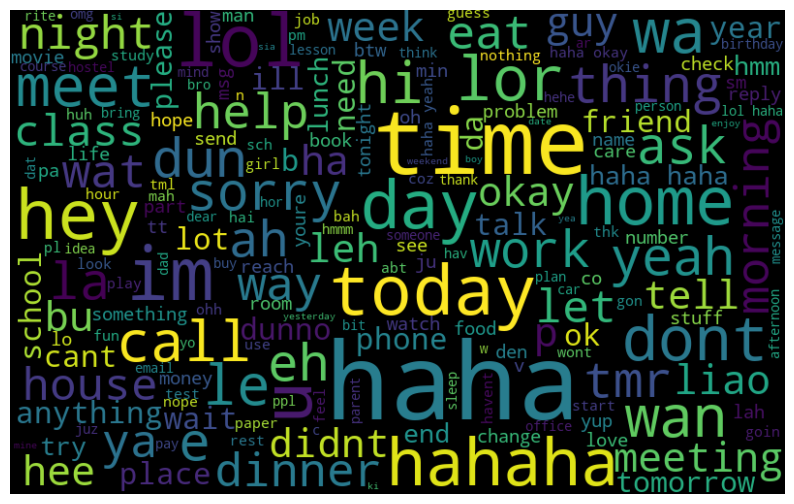

In [28]:
#create wordcloud from nouns
all_nouns = ' '.join(nouns)
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_nouns)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

POS tagging noun-phrases in message to view most common topics with a different method to see how it compares.

In [29]:
#create pos tagged sentences from message_lemmatized_nostop
pos_tagged_sentences = []
for sentence in data['message_lemmatized_nostop']:
    pos_tagged_sentences.append(pos_tag(sentence))

In [30]:
#create noun phrase chunker
chunk_grammar = 'NP: {<DT>?<JJ>*<NN>}'
chunk_parser = RegexpParser(chunk_grammar)

np_chunked = []
for sentence in pos_tagged_sentences:
    if sentence:
        np_chunked.append(chunk_parser.parse(sentence))
np_chunked[:10]        


[Tree('S', [Tree('NP', [('bugis', 'NN')]), Tree('NP', [('oso', 'NN')]), ('near', 'IN'), Tree('NP', [('wat', 'NN')])]),
 Tree('S', [('go', 'VB'), Tree('NP', [('jurong', 'JJ'), ('point', 'NN')]), Tree('NP', [('crazy', 'NN')]), Tree('NP', [('available', 'JJ'), ('bugis', 'NN')]), ('n', 'RB'), Tree('NP', [('great', 'JJ'), ('world', 'NN')]), Tree('NP', [('la', 'NN')]), ('e', 'VBP'), Tree('NP', [('buffet', 'JJ'), ('cine', 'NN')]), ('got', 'VBD'), ('amore', 'RB'), ('wat', 'JJ')]),
 Tree('S', [Tree('NP', [('dunno', 'NN')]), Tree('NP', [('let', 'NN')]), ('go', 'VB'), Tree('NP', [('learn', 'JJ'), ('pilate', 'NN')])]),
 Tree('S', [Tree('NP', [('den', 'JJ'), ('weekday', 'NN')]), ('got', 'VBD'), Tree('NP', [('special', 'JJ'), ('price', 'NN')]), Tree('NP', [('haiz', 'NN')]), Tree('NP', [('cant', 'JJ'), ('eat', 'NN')]), Tree('NP', [('liao', 'NN')]), Tree('NP', [('cut', 'NN')]), Tree('NP', [('nail', 'NN')]), Tree('NP', [('oso', 'NN')]), Tree('NP', [('muz', 'NN')]), ('wait', 'VBP'), Tree('NP', [('finish

In [31]:
#extract chunks from np_chunked
chunks = []
for chunked_sentence in np_chunked:
        for subtree in chunked_sentence.subtrees(filter=lambda t: t.label() == 'NP'):
            chunks.append(tuple(subtree))  
chunks[:10]             

[(('bugis', 'NN'),),
 (('oso', 'NN'),),
 (('wat', 'NN'),),
 (('jurong', 'JJ'), ('point', 'NN')),
 (('crazy', 'NN'),),
 (('available', 'JJ'), ('bugis', 'NN')),
 (('great', 'JJ'), ('world', 'NN')),
 (('la', 'NN'),),
 (('buffet', 'JJ'), ('cine', 'NN')),
 (('dunno', 'NN'),)]

Most common noun-phrases seems similar to using previous methods

In [32]:
#create chunk counter
chunk_counter = Counter(chunks)
chunk_counter.most_common(20)

[((('haha', 'NN'),), 4675),
 ((('lol', 'NN'),), 1850),
 ((('u', 'NN'),), 1719),
 ((('im', 'NN'),), 1361),
 ((('hey', 'NN'),), 1256),
 ((('hahaha', 'NN'),), 1178),
 ((('home', 'NN'),), 1128),
 ((('time', 'NN'),), 994),
 ((('hi', 'NN'),), 966),
 ((('le', 'NN'),), 899),
 ((('today', 'NN'),), 888),
 ((('yeah', 'NN'),), 792),
 ((('call', 'NN'),), 717),
 ((('dont', 'NN'),), 709),
 ((('okay', 'NN'),), 694),
 ((('wa', 'NN'),), 683),
 ((('lor', 'NN'),), 681),
 ((('sorry', 'NN'),), 647),
 ((('r', 'NN'),), 640),
 ((('dun', 'NN'),), 635)]

Creating a setiment analysis using the 'SentimentIntensityAnalyzer' model from NLTK using the orginal messages and creating a new column named "sentiment".

In [33]:
#Sentiment Analysis
sia = SentimentIntensityAnalyzer()
data['sentiment'] = data['Message'].apply(lambda x: sia.polarity_scores(x))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w...","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6..."
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia...","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}"
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


Creating a new 'sentiment_tag' column to classify the message as positive, negative or neutral.

In [34]:
#create column for positive, neutral, negative sentiment
data['sentiment_tag'] = data['sentiment'].apply(lambda x: 'positive' if x['compound'] > 0 else('neutral' if x['compound'] == 0 else 'negative'))
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment,sentiment_tag
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w...","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6...",positive
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia...","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}",positive
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral


Creating a plot to visualize the number of positive, negative and neutral messages as per the pre-trained model

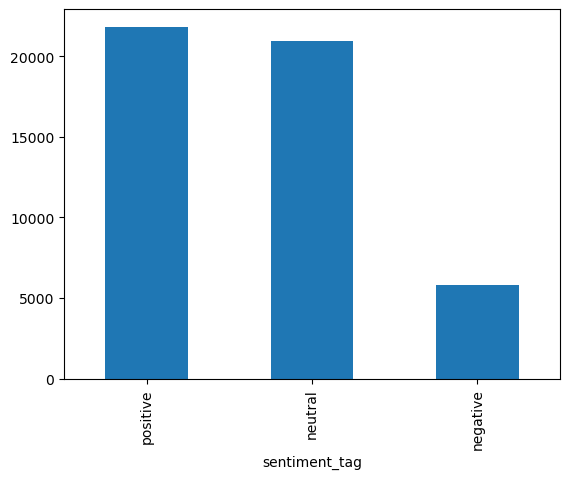

In [35]:
#plot positive and negative sentiment 
data['sentiment_tag'].value_counts().plot(kind='bar')
plt.show()

In [36]:
#sentiment_tag percentage
data['sentiment_tag'].value_counts(normalize=True)*100

sentiment_tag
positive    44.941206
neutral     43.106324
negative    11.952470
Name: proportion, dtype: float64

Creating a 'sentiment_score' column by extracting the 'compound' score

In [37]:
#create sentiment score column 
data['sentiment_score'] = data['sentiment'].apply(lambda x: x['compound'])
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment,sentiment_tag,sentiment_score
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n gr...,"[go, until, jurong, point, crazy, available, only, in, b...","[go, until, jurong, point, crazy, available, only, in, b...","[go, jurong, point, crazy, available, bugis, n, great, w...","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6...",positive,0.6249
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000
3,3,10123,Den only weekdays got special price... Haiz... Cant eat ...,140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao c...,"[den, only, weekdays, got, special, price, haiz, cant, e...","[den, only, weekday, got, special, price, haiz, cant, ea...","[den, weekday, got, special, price, haiz, cant, eat, lia...","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}",positive,0.5445
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000


Creating a bar plot to visualize the sentiment scores by country to see which countries tend the send the most positive messages

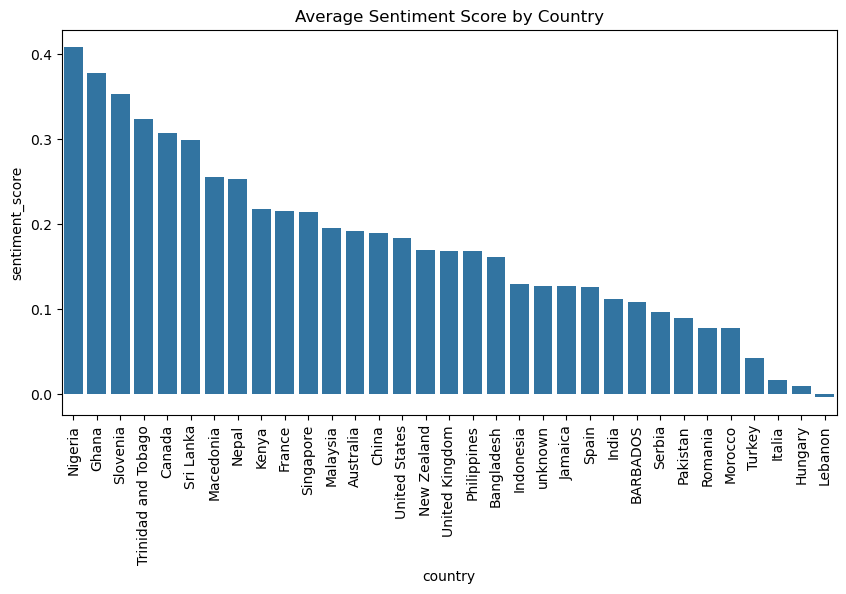

In [38]:
#group by country and sentiment
country_sentiment = data.groupby(['country'])['sentiment_score'].mean().reset_index()
country_sentiment = country_sentiment.sort_values(by='sentiment_score', ascending=False)
# create a barplot for country and sentiment
plt.figure(figsize=(10, 5))
sns.barplot(x='country', y='sentiment_score', data=country_sentiment)  
plt.xticks(rotation=90)
plt.title('Average Sentiment Score by Country')
plt.show()

Filtering the dataframe to only include messages tagged as 'positive' and creating a wordcloud to visualize the most common words used in 'positive' messages.

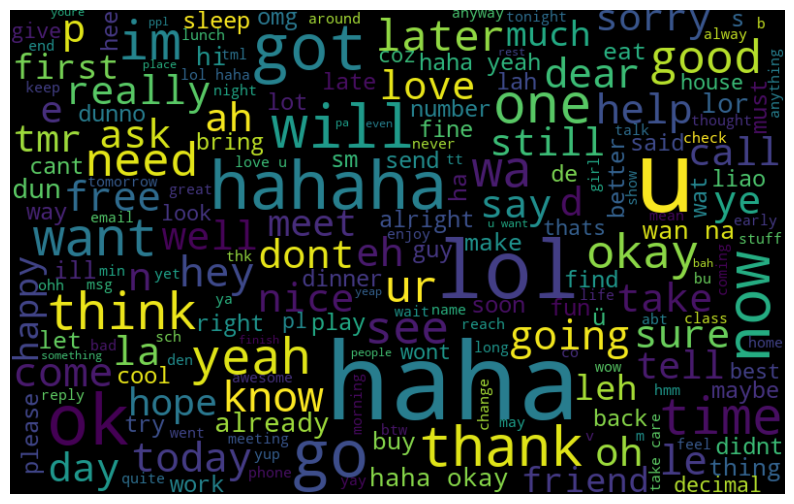

In [39]:
#create wordcloud from message_lemmatized where sentiment is positive
pos_words = ' '.join([' '.join(text) for text in data[data['sentiment_tag'] == 'positive']['message_lemmatized']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Filtering the dataframe to only include messages tagged as 'negative' and creating a wordcloud to visualize the most common words used in 'negative' messages.

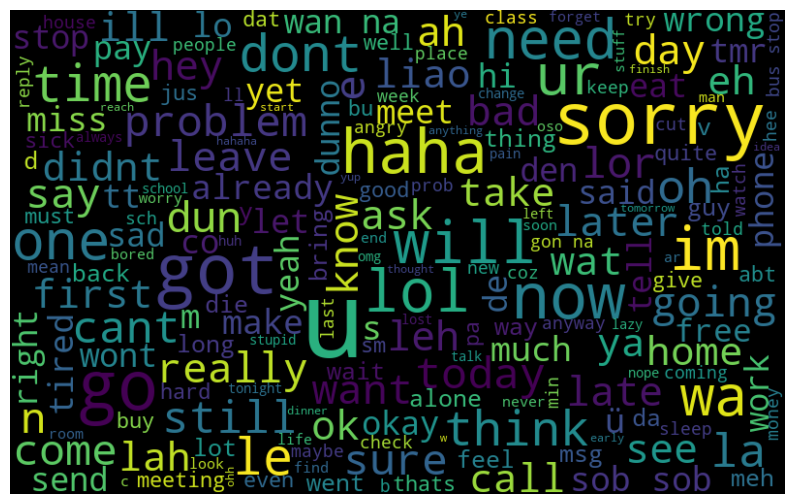

In [40]:
#create wordcloud from message_lemmatized where sentiment is negative
neg_words = ' '.join([' '.join(text) for text in data[data['sentiment_tag'] == 'negative']['message_lemmatized']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Viewing a sample of messages classified as negative

In [41]:
pd.set_option('display.max_colwidth', None)
#create dataframe of negative sentiment
negative_messages = data[data['sentiment_tag'] == 'negative']
negative_messages.Message[:20]

20                                                                                       Haiyoh... Maybe your hamster was jealous of million
21                                                                           is your hamster dead? Hey so tmr i meet you at 1pm orchard mrt?
36                                                       ll go yan jiu too... We can skip ard oso, go cine den go mrt one, blah blah blah...
39                                                                                             Haha... Sounds crazy, dunno can tahan anot...
41             Oh... I was thkin of goin yogasana at 10 den no nd to go at 3 den can rush to parco 4 nb... Okie lor, u call me when ready...
42                               After my work ah... Den 6 plus lor... U workin oso rite... Den go orchard lor, no other place to go liao...
49                                                           Yup... Hey then one day on fri we can ask miwa and jiayin take leave go karaoke
63     Oh... 

Viewing a sample of messages classified as positive

In [42]:
pd.set_option('display.max_colwidth', None)
#create dataframe of positive sentiment
positive_messages = data[data['sentiment_tag'] == 'positive']
positive_messages.Message[:20]

1                                                     Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
3                        Den only weekdays got special price... Haiz... Cant eat liao... Cut nails oso muz wait until i finish drivin wat, lunch still muz eat wat...
10                                                                                                                          Oh...i asked for fun. Haha...take care. ü
16                                                 s a basic yoga course... at bugis... We can go for that... Pilates intro next sat.... Tell me what time you r free
22                                                                                                              ve booked the pilates and yoga lesson already... Haha
23                                                                            Yup... I havent been there before... You want to go for the yoga? I can call up to book
26  

Let's create our own model to see how it compares using the "Twitter Sentiment Dataset" by HUSSEIN, SHERIF (2021) found at https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset

In [43]:
#load twitter data and preview
twitter_df = pd.read_csv('Tweets.csv')
twitter_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


This dataset has 27,481 rows and 4 columns

In [44]:
#check the shape
twitter_df.shape

(27481, 4)

Checking the distribution of sentiments.  The distribution is not even so we will address that below

In [45]:
#check the distribution of category scores
twitter_df.sentiment.value_counts()

sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

In [46]:
#check for missing values
twitter_df.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

Dropping 1 row with null value

In [47]:
#drop missing values
twitter_df = twitter_df.dropna()

Dropping columns that aren't needed

In [48]:
#drop textID and selected_text columns
twitter_df = twitter_df.drop(['textID', 'selected_text'], axis=1)
twitter_df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative


Creating a copy of the dataframe for later use to experiement with

In [49]:
#create copy of twitter_df
twitter_df2 = twitter_df
#drop null values
twitter_df2 = twitter_df2.dropna()

Preprocessing the messages in a new `text_cleaned` column by applying the following:
- lowercase
- remove punctuation
- removing urls
- tokenizing
- lemmatizing
- removing stopwords

In [50]:
#convert text column to lowercase
twitter_df['text_cleaned'] = twitter_df['text'].str.lower()

#Remove punctuation
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: remove_punct(x))

#Remove urls
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: remove_url(x))

#tokenize
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: tokenize(x))

#Lemmatize
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

#Remove stopwords
twitter_df['text_cleaned'] = twitter_df['text_cleaned'].apply(lambda x: remove_stopwords(x))
twitter_df.head()

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,"[id, responded, going]"
1,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,negative,"[bos, bullying]"
3,what interview! leave me alone,negative,"[interview, leave, alone]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,"[son, couldnt, put, release, already, bought]"


Saving messages from each sentiment (positive, negative, neutral) to it's own variable and sampling down the positive and neutral messages so that the distribution is even

In [51]:
#save negative tweets to a new variable
negative_tweets = twitter_df[twitter_df['sentiment'] == 'negative']

#save a random sample of 7781 positive tweets to a new variable
positive_tweets = twitter_df[twitter_df['sentiment'] == 'positive'].sample(7781)

#save a random sample of 7781 neutral tweets to a new variable
neutral_tweets = twitter_df[twitter_df['sentiment'] == 'neutral'].sample(7781)

Visualizing the count of each sentiment to ensure an unbiased distribution

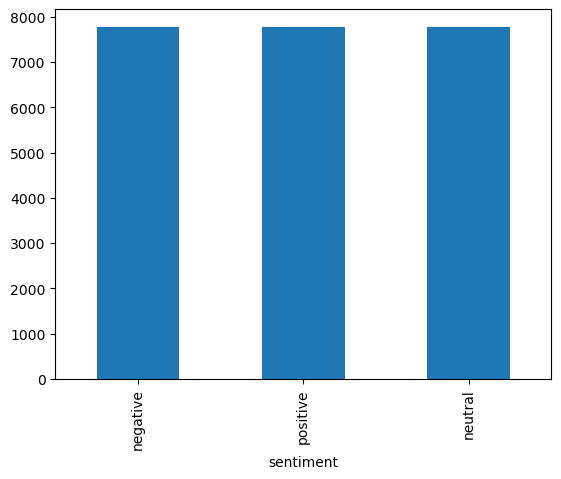

In [52]:
#create new dataframe with all tweets
new_twitter_df = pd.concat([negative_tweets, positive_tweets, neutral_tweets], ignore_index=True)

#plot distribution of sentiment
new_twitter_df['sentiment'].value_counts().plot(kind='bar')
plt.show()

Shuffling the rows at random

In [53]:
#shuffle dataframe
seed = 42
new_twitter_df = new_twitter_df.sample(frac=1, random_state=seed).reset_index(drop=True)

new_twitter_df.head()

,text,sentiment,text_cleaned
0,you can put a saucepan full of water on the cooker to heat up the water...indian style scrabbled are the best!!!!,positive,"[put, saucepan, full, water, cooker, heat, waterindian, style, scrabbled, best]"
1,Happy Mothers Day. Havent got mom a present yet? Print off an Amazon Gift Card for her! http://snipurl.com/hq0n1,positive,"[happy, mother, day, havent, got, mom, present, yet, print, amazon, gift, card, httpsnipurlcomhq0n1]"
2,I am filming musicans friends of mine at a Legion These people sure know how to dance,neutral,"[filming, musicans, friend, mine, legion, people, sure, know, dance]"
3,has the day open until 4. don`t know what to do. everyone is leaving today,neutral,"[ha, day, open, 4, dont, know, everyone, leaving, today]"
4,http://twitpic.com/4fzo7 - When you`ll come in Bulgaria??? You have a great fans here!,positive,"[httptwitpiccom4fzo7, youll, come, bulgaria, great, fan]"


Creating a `text_cleaned_str` column to convert our tokens back to a string for each row.

In [54]:
#convert text_cleaned into strings
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned'].apply(lambda x: ' '.join(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,you can put a saucepan full of water on the cooker to heat up the water...indian style scrabbled are the best!!!!,positive,"[put, saucepan, full, water, cooker, heat, waterindian, style, scrabbled, best]",put saucepan full water cooker heat waterindian style scrabbled best
1,Happy Mothers Day. Havent got mom a present yet? Print off an Amazon Gift Card for her! http://snipurl.com/hq0n1,positive,"[happy, mother, day, havent, got, mom, present, yet, print, amazon, gift, card, httpsnipurlcomhq0n1]",happy mother day havent got mom present yet print amazon gift card httpsnipurlcomhq0n1
2,I am filming musicans friends of mine at a Legion These people sure know how to dance,neutral,"[filming, musicans, friend, mine, legion, people, sure, know, dance]",filming musicans friend mine legion people sure know dance
3,has the day open until 4. don`t know what to do. everyone is leaving today,neutral,"[ha, day, open, 4, dont, know, everyone, leaving, today]",ha day open 4 dont know everyone leaving today
4,http://twitpic.com/4fzo7 - When you`ll come in Bulgaria??? You have a great fans here!,positive,"[httptwitpiccom4fzo7, youll, come, bulgaria, great, fan]",httptwitpiccom4fzo7 youll come bulgaria great fan


Further processing the `text_cleaned_str` column by stemming the words

In [55]:
#Define function to stem text_cleaned_str
def stem_text(text):
    ps = PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

#Apply function to text_cleaned_str
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned_str'].apply(lambda x: stem_text(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,you can put a saucepan full of water on the cooker to heat up the water...indian style scrabbled are the best!!!!,positive,"[put, saucepan, full, water, cooker, heat, waterindian, style, scrabbled, best]",put saucepan full water cooker heat waterindian style scrabbl best
1,Happy Mothers Day. Havent got mom a present yet? Print off an Amazon Gift Card for her! http://snipurl.com/hq0n1,positive,"[happy, mother, day, havent, got, mom, present, yet, print, amazon, gift, card, httpsnipurlcomhq0n1]",happi mother day havent got mom present yet print amazon gift card httpsnipurlcomhq0n1
2,I am filming musicans friends of mine at a Legion These people sure know how to dance,neutral,"[filming, musicans, friend, mine, legion, people, sure, know, dance]",film musican friend mine legion peopl sure know danc
3,has the day open until 4. don`t know what to do. everyone is leaving today,neutral,"[ha, day, open, 4, dont, know, everyone, leaving, today]",ha day open 4 dont know everyon leav today
4,http://twitpic.com/4fzo7 - When you`ll come in Bulgaria??? You have a great fans here!,positive,"[httptwitpiccom4fzo7, youll, come, bulgaria, great, fan]",httptwitpiccom4fzo7 youll come bulgaria great fan


Removing repeating characters

In [56]:
#define function to remove repeating characters
def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text) 

#Apply function to text_cleaned_str
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned_str'].apply(lambda x: remove_repeating_char(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,you can put a saucepan full of water on the cooker to heat up the water...indian style scrabbled are the best!!!!,positive,"[put, saucepan, full, water, cooker, heat, waterindian, style, scrabbled, best]",put saucepan ful water coker heat waterindian style scrabl best
1,Happy Mothers Day. Havent got mom a present yet? Print off an Amazon Gift Card for her! http://snipurl.com/hq0n1,positive,"[happy, mother, day, havent, got, mom, present, yet, print, amazon, gift, card, httpsnipurlcomhq0n1]",hapi mother day havent got mom present yet print amazon gift card htpsnipurlcomhq0n1
2,I am filming musicans friends of mine at a Legion These people sure know how to dance,neutral,"[filming, musicans, friend, mine, legion, people, sure, know, dance]",film musican friend mine legion peopl sure know danc
3,has the day open until 4. don`t know what to do. everyone is leaving today,neutral,"[ha, day, open, 4, dont, know, everyone, leaving, today]",ha day open 4 dont know everyon leav today
4,http://twitpic.com/4fzo7 - When you`ll come in Bulgaria??? You have a great fans here!,positive,"[httptwitpiccom4fzo7, youll, come, bulgaria, great, fan]",htptwitpicom4fzo7 youl come bulgaria great fan


Removing numbers from our messages

In [57]:
#define function to remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

#Apply function to text_cleaned_str
new_twitter_df['text_cleaned_str'] = new_twitter_df['text_cleaned_str'].apply(lambda x: remove_numbers(x))
new_twitter_df.head()

,text,sentiment,text_cleaned,text_cleaned_str
0,you can put a saucepan full of water on the cooker to heat up the water...indian style scrabbled are the best!!!!,positive,"[put, saucepan, full, water, cooker, heat, waterindian, style, scrabbled, best]",put saucepan ful water coker heat waterindian style scrabl best
1,Happy Mothers Day. Havent got mom a present yet? Print off an Amazon Gift Card for her! http://snipurl.com/hq0n1,positive,"[happy, mother, day, havent, got, mom, present, yet, print, amazon, gift, card, httpsnipurlcomhq0n1]",hapi mother day havent got mom present yet print amazon gift card htpsnipurlcomhqn
2,I am filming musicans friends of mine at a Legion These people sure know how to dance,neutral,"[filming, musicans, friend, mine, legion, people, sure, know, dance]",film musican friend mine legion peopl sure know danc
3,has the day open until 4. don`t know what to do. everyone is leaving today,neutral,"[ha, day, open, 4, dont, know, everyone, leaving, today]",ha day open dont know everyon leav today
4,http://twitpic.com/4fzo7 - When you`ll come in Bulgaria??? You have a great fans here!,positive,"[httptwitpiccom4fzo7, youll, come, bulgaria, great, fan]",htptwitpicomfzo youl come bulgaria great fan


Splitting our data into train and test variables for our models

In [58]:
X = new_twitter_df['text_cleaned_str']
y = new_twitter_df['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Creating a pipeline and using the Naive Bayes Classifer to fit our model.  After fine tuning the parameters, the highest score achieved was 67%

In [59]:
#Create a Pipeline consisting of "CountVectorizer", "TfidfTransformer", and the classifier "MultinomialNB" 
pipe = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_df=1.0,
                                 max_features=None, min_df=4,
                                 ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
    ('clf', MultinomialNB(alpha=8, class_prior=None, fit_prior=True))
])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6676659528907923

Creating a second pipeline using the Random Forest Classifer.  After fine turing the parameters, the highest score achieved was 71.4%

In [60]:
#Create a Pipeline consisting of "CountVectorizer", "TfidfTransformer", and the classifier "MultinomialNB" 
pipe2 = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_df=0.8,
                                 max_features=None, min_df=4,
                                 ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
    ('rfc', RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42,
                                   criterion='gini', max_features='sqrt'))
])
pipe2.fit(X_train, y_train)
pipe2.score(X_test, y_test)

0.7109207708779444

Creating a third pipeline using the Linear SVC Classifer.  After fine turing the parameters, the highest score achieved was 69.1%

In [61]:
#Create a Pipeline consisting of "CountVectorizer", "TfidfTransformer", and the classifier "MultinomialNB" 
pipe3 = Pipeline([
    ('vect', CountVectorizer(lowercase=True, max_df=1.0,
                                 max_features=None, min_df=4,
                                 ngram_range=(1, 1))),
    ('tfidf', TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=False)),
    ('svm', svm.LinearSVC())
])
pipe3.fit(X_train, y_train)
pipe3.score(X_test, y_test)

0.6963597430406853

Using a copy of the dataset we created earlier, we'll preprocess the messages again in a slightly different way to see if we can yield better results

In [62]:
#save sentiment tweets to new variable
negative_tweets2 = twitter_df2[twitter_df2['sentiment'] == 'negative']
positive_tweets2 = twitter_df2[twitter_df2['sentiment'] == 'positive'].sample(7781)
neutral_tweets2 = twitter_df2[twitter_df2['sentiment'] == 'neutral'].sample(7781)

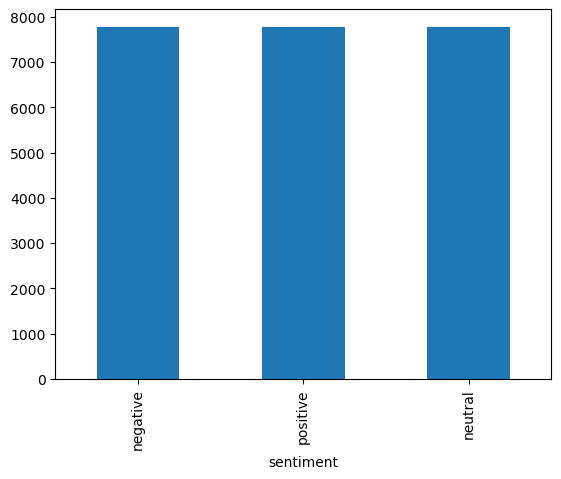

In [63]:
#create new dataframe with all tweets
new_twitter_df2 = pd.concat([negative_tweets2, positive_tweets2, neutral_tweets2], ignore_index=True)

#plot distribution of sentiment
new_twitter_df2['sentiment'].value_counts().plot(kind='bar')
plt.show()

In [64]:
#shuffle dataframe
seed = 42
new_twitter_df2 = new_twitter_df2.sample(frac=1, random_state=seed).reset_index(drop=True)

new_twitter_df2.head()

,text,sentiment
0,Um... happy star wars day btw. Cheers to all you scruffy looking nerfherders and hot ami`s out there.,positive
1,good night..have to get up so early tomorrow,positive
2,you should come over before friday and teach me how,neutral
3,last day off... back to work tomorrow,neutral
4,haha..yeah..10th of May..lol..im greeting in advance! haha,positive


Lowercasing our messages

In [65]:
#create new text_cleaned column with lowercased text
twitter_df2['text_cleaned'] = twitter_df2['text'].str.lower()
twitter_df2.head()

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,"i`d have responded, if i were going"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad i will miss you here in san diego!!!
2,my boss is bullying me...,negative,my boss is bullying me...
3,what interview! leave me alone,negative,what interview! leave me alone
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,"sons of ****, why couldn`t they put them on the releases we already bought"


Importing the emoji library and using it to convert any possible emojis to text.

In [66]:
import emoji 
#convert emoticons to text
def convert_emojis(text):
    return emoji.demojize(text)

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: convert_emojis(x))

Creating a function to replace common emoticons with text so that these sentiments can be preserved when we remove punctuation 

In [67]:
#replace emoticon with dictionary key  
def replace_emoticons(text):
    emoticon_dict = {
        'smile' : [':-)', ':)', ':-]', ':]', ':->', ':>', '8-)', '8)', ':-}', ':}',	':^)','=]',	'=)', ':-))', ':))'],
        'laugh' : [':-D', ':D'],
        'sad' : [':-(', ':(', ':-c', ':c',	':-<', ':<', ':-[', ':[]', ':(', ';(', '</3'],
        'angry' : ['>:(', '>:[]'],
        'love' : ['<3', ]
    }
    for emotion, emoticon in emoticon_dict.items():
        for e in emoticon:
            text = text.replace(e, emotion)
    
    return text

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: replace_emoticons(x))

Creating a function to replace 3 or more consecutive letters with only 2.  Previously, we replaced consecutive letters down to only 1.

In [68]:
#replace 3 or more consecutive letters with double letter   
def replace_consecutive_letters(text):
    return re.sub(r'(.)\1{3,}', r'\1\1', text)

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: replace_consecutive_letters(x))

Removing urls

In [69]:
#remove urls
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_url(x))

Removing punctuation

In [70]:
#remove punctuation
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_punct(x))

Removing all non-letter characters from our messages thus only keeping characters from a to z.

In [71]:
#create function to remove non letters from a-z
def remove_non_letters(text):
    return re.sub(r'[^a-z]', ' ', text)

twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_non_letters(x))

Tokenizing, lemmatizing and removing stopwords.

In [72]:
#tokenize
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: word_tokenize(x))

In [73]:
#Lemmatize
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])

In [74]:
#remove stopwords from each row in text_cleaned from twitter_df2 
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: remove_stopwords(x))

In [75]:
twitter_df2.head()

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,"[id, responded, going]"
1,Sooo SAD I will miss you here in San Diego!!!,negative,"[sooo, sad, miss, san, diego]"
2,my boss is bullying me...,negative,"[bos, bullying]"
3,what interview! leave me alone,negative,"[interview, leave, alone]"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,"[son, couldnt, put, release, already, bought]"


Joining the tokens to create strings for our modelling

In [76]:
#join tokenized text in text_cleaned column
twitter_df2['text_cleaned'] = twitter_df2['text_cleaned'].apply(lambda x: ' '.join(x))
twitter_df2.head()

,text,sentiment,text_cleaned
0,"I`d have responded, if I were going",neutral,id responded going
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego
2,my boss is bullying me...,negative,bos bullying
3,what interview! leave me alone,negative,interview leave alone
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,son couldnt put release already bought


Assigning our features and target variables and creating training and testing splits

In [77]:
#create test and train sets from new_twitter_df2
X2 = twitter_df2['text_cleaned']
y2 = twitter_df2['sentiment']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.1, random_state=42)
y_train2.shape

(24732,)

Vectorizing our feature sets for the Tf-Idf transformer

In [78]:
#count vectorizer on twitter_df2
vectoriser = CountVectorizer(lowercase=True, max_df=0.9,
                                 max_features=5000, min_df=2,
                                 ngram_range=(1, 2))
X2_train_counts = vectoriser.fit_transform(X_train2)
X2_test_counts = vectoriser.transform(X_test2)
X2_train_counts.shape



(24732, 5000)

Transforming our features into Tf-Idf values

In [79]:
#tfidf transformer on twitter_df2
tfidf = TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)
X2_train_tfidf = tfidf.fit_transform(X2_train_counts)
X2_test_tfidf = tfidf.transform(X2_test_counts) 
X2_train_tfidf.shape

(24732, 5000)

Creating a Naive Bayes Classifer model.  The accuracy of this model is 64.5%

In [80]:
#create multinomialNB on twitter_df2
clf = MultinomialNB(alpha=2, class_prior=None, fit_prior=True)
clf.fit(X2_train_tfidf, y_train2)
y_pred = clf.predict(X2_test_tfidf)
score = clf.score(X2_test_tfidf, y_test2)
print('Score:', score)
f1 = round(f1_score(y_test2, y_pred, average='macro'), 2)
recall = round(recall_score(y_test2, y_pred, average='macro'), 2)
accuracy = accuracy_score(y_test2, y_pred)
print('F1 Score:', f1)
print('Recall Score:', recall)
print('Accuracy Score:', accuracy)

Score: 0.6448326055312955
F1 Score: 0.63
Recall Score: 0.62
Accuracy Score: 0.6448326055312955


Creating a Linear SVC model.  The accuracy of this model is 66.7%

In [81]:
#create LinearSVC on twitter_df2
clf2 = svm.LinearSVC()
clf2.fit(X2_train_tfidf, y_train2)
y_pred = clf2.predict(X2_test_tfidf)
score = clf2.score(X2_test_tfidf, y_test2)
print('Score:', score)

Score: 0.6666666666666666


Creating a Random Forest Classifer.  The accuracy of this model is 69.7%

In [82]:
#create Random Forest on twitter_df2
clf3 = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42,
                                   criterion='gini', max_features='sqrt')
clf3.fit(X2_train_tfidf, y_train2)
y_pred = clf3.predict(X2_test_tfidf)
score = clf3.score(X2_test_tfidf, y_test2)
print('Score:', score)


Score: 0.6972343522561864


Let's now compare the Sentiment Intensity Analyser to compare the performance of our models against it

In [83]:
#SentimentIntensityAnalyzer with twitter_df2
sia2 = SentimentIntensityAnalyzer()
twitter_df2['pred_scores'] = twitter_df2['text'].apply(lambda x: sia.polarity_scores(x))
twitter_df2.head()


,text,sentiment,text_cleaned,pred_scores
0,"I`d have responded, if I were going",neutral,id responded going,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.7437}"
2,my boss is bullying me...,negative,bos bullying,"{'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.5994}"
3,what interview! leave me alone,negative,interview leave alone,"{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.3595}"
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,son couldnt put release already bought,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"


Creating a new `pred_senti` column to contain the predictions from the Sentiment Intensity Analyzer

In [84]:
#create predicted sentiment column
twitter_df2['pred_senti'] = twitter_df2['pred_scores'].apply(lambda x: 'positive' if x['compound'] > 0.05 else ('neutral' if x['compound'] > -0.05 else 'negative'))
twitter_df2.head()

,text,sentiment,text_cleaned,pred_scores,pred_senti
0,"I`d have responded, if I were going",neutral,id responded going,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative,sooo sad miss san diego,"{'neg': 0.474, 'neu': 0.526, 'pos': 0.0, 'compound': -0.7437}",negative
2,my boss is bullying me...,negative,bos bullying,"{'neg': 0.494, 'neu': 0.506, 'pos': 0.0, 'compound': -0.5994}",negative
3,what interview! leave me alone,negative,interview leave alone,"{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.3595}",negative
4,"Sons of ****, why couldn`t they put them on the releases we already bought",negative,son couldnt put release already bought,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral


Comparing the Sentiment Analyzer predicitons with the actual tags from the original dataset.  The result is 63.1% which is actually less than all of our models

In [85]:
score3 = accuracy_score(twitter_df2['sentiment'], twitter_df2['pred_senti'])
score3

0.631259097525473

Pipe2 was our best model so let's use it to make sentiment predicitons on our original `data` dataset

In [86]:
#use pipe2 to predict sentiment on data 
y_pred = pipe2.predict(data['Message'])
y_pred.shape

(48559,)

Creating a new column `pipe2_pred` to contain the model's predicitons

In [87]:
#create pipe2_pred column in data
data['pipe2_pred'] = y_pred
data.head()

,Unnamed: 0,id,Message,length,country,Date,message_cleaned,message_tokenized,message_lemmatized,message_lemmatized_nostop,sentiment,sentiment_tag,sentiment_score,pipe2_pred
0,0,10120,Bugis oso near wat...,21,Singapore,2003/4,bugis oso near wat,"[bugis, oso, near, wat]","[bugis, oso, near, wat]","[bugis, oso, near, wat]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000,neutral
1,1,10121,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",111,Singapore,2003/4,go until jurong point crazy available only in bugis n great world la e buffet cine there got amore wat,"[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]","[go, until, jurong, point, crazy, available, only, in, bugis, n, great, world, la, e, buffet, cine, there, got, amore, wat]","[go, jurong, point, crazy, available, bugis, n, great, world, la, e, buffet, cine, got, amore, wat]","{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'compound': 0.6249}",positive,0.6249,positive
2,2,10122,I dunno until when... Lets go learn pilates...,46,Singapore,2003/4,i dunno until when lets go learn pilates,"[i, dunno, until, when, lets, go, learn, pilates]","[i, dunno, until, when, let, go, learn, pilate]","[dunno, let, go, learn, pilate]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000,neutral
3,3,10123,"Den only weekdays got special price... Haiz... Cant eat liao... Cut nails oso muz wait until i finish drivin wat, lunch still muz eat wat...",140,Singapore,2003/4,den only weekdays got special price haiz cant eat liao cut nails oso muz wait until i finish drivin wat lunch still muz eat wat,"[den, only, weekdays, got, special, price, haiz, cant, eat, liao, cut, nails, oso, muz, wait, until, i, finish, drivin, wat, lunch, still, muz, eat, wat]","[den, only, weekday, got, special, price, haiz, cant, eat, liao, cut, nail, oso, muz, wait, until, i, finish, drivin, wat, lunch, still, muz, eat, wat]","[den, weekday, got, special, price, haiz, cant, eat, liao, cut, nail, oso, muz, wait, finish, drivin, wat, lunch, still, muz, eat, wat]","{'neg': 0.0, 'neu': 0.83, 'pos': 0.17, 'compound': 0.5445}",positive,0.5445,negative
4,4,10124,Meet after lunch la...,22,Singapore,2003/4,meet after lunch la,"[meet, after, lunch, la]","[meet, after, lunch, la]","[meet, lunch, la]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}",neutral,0.0000,neutral


The distribution of sentiments according to our model was:
- Neutral: 76%
- Negative: 13.3%
- Positive: 10.7%

In [88]:
#get percentage of each sentiment from pipe2_pred
data['pipe2_pred'].value_counts(normalize=True)

pipe2_pred
neutral     0.743281
negative    0.145905
positive    0.110814
Name: proportion, dtype: float64

Create a new wordcloud of words found in messages classified as positive

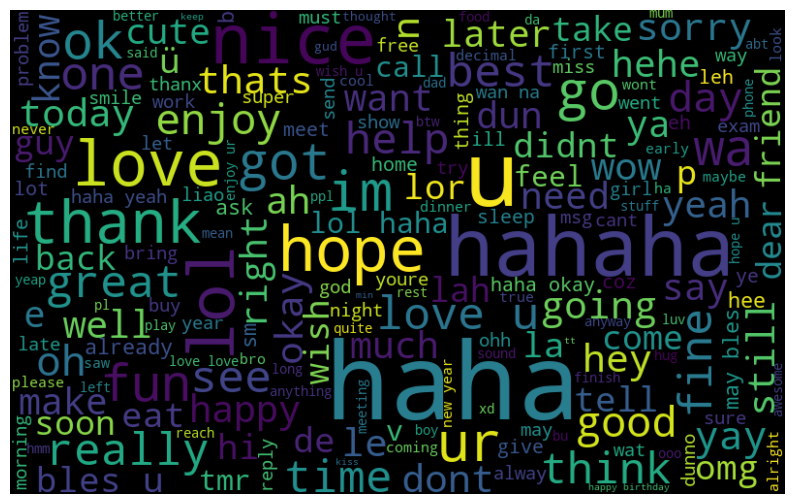

In [89]:
#create wordcloud from pipe2_pred where sentiment is positive
pos_words = ' '.join([' '.join(text) for text in data[data['pipe2_pred'] == 'positive']['message_lemmatized_nostop']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(pos_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Create a new wordcloud of words found in messages classified as negative

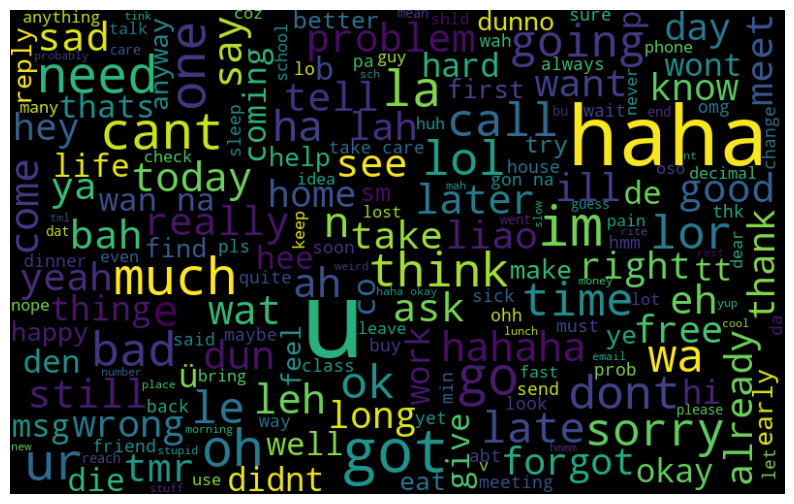

In [90]:
#create wordcloud from pipe2_pred where sentiment is negative
neg_words = ' '.join([' '.join(text) for text in data[data['pipe2_pred'] == 'negative']['message_lemmatized_nostop']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neg_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

View sample of messages classified as negative.

In [91]:
#preview random sample of messages where pipe2_pred is negative
data.Message[data['pipe2_pred'] == 'negative'].sample(10)   

17381                                                                                                                                                                   K I'll take care of it
27623                                                                                                                                                                         tj pagar.. haha.
33619                                                                                    Anna its me baba.pls let me know to dis no how to reach wallawatta frm NUGEGODA.i dont hav charge.bye
18539                                                                                                                                                                   Will be you when done.
18916                                                                        Oh I feel you. So many silly technical difficulties just to answer their pointless and banal questions. My. Word.
3895                                         

View sample of messages classified as positive.

In [92]:
#preview random sample of messages where pipe2_pred is positive
data.Message[data['pipe2_pred'] == 'positive'].sample(10)

18815                                                                                                                                           Yeah for sure! Thank you
2497                                                                                                                                                            Gd luck!
18717                                                                                                                                              WISH A HAPPY JOURNEY.
28239                                                                                                                                U going for dinner now right.? Hehe
2667                                                                                                                        i will reach the busstop 15 mins later..hehe
45811                                                                                                                                                     K

View a sample of messages classified as neutral.

In [93]:
#preview random sample of messages where pipe2_pred is neutral
data.Message[data['pipe2_pred'] == 'neutral'].sample(10)

17829                                                                                                                                                                                                K actually can you guys meet me at the sunoco on howard? It should be right on the way
31058                                                                                                                                                                                                                                                              Then just say cannot la.
38492                                                                                                                                                                                                                                     Yeah out for lunch. You all gym without me. Sian.
37186                                                                                                                                               

## Summary

In this project, I used a range of NLP methods to experiment with sentiment analysis on SMS text messages.  I first applied various data cleaning and pre-processing techniques on the "clean_nus_sms.csv" dataset and applied the "SentimentIntensityAnalyzer" model from NLTK to gather various insights.

This model predicted that 45% of the message were positive, 43% were neutral and 12% were negative.  This model also concluded that the top 5 countries with the highest positive sentiment were: Nigeria, Ghana, Slovenia, Trinidad and Tobago, and Canada.  The top 5 countries with the highest negative sentiment were: Lebanon, Hungary, Italia, Turkey and Morocco.

Using this model, I was able to generate word clouds that were able to show the most common words used in positive and negative messages.

I then experimented with the "Tweets.csv" dataset applying various pre-processing techniques and creating 3 different models to predict the sentiment of the messages.  I found that the Random Forest model was the best model with a score of 71.4%.

I then used a copy of the "Tweets.csv" dataset and experimented with different pre-processing techniques to see if I could yield better results but could not improve upon the previous results.

Next, I applied the "pipe_2" model to our original "clean_nus_sms.csv" dataset and found that the model predicted that 10.7% of the messages were positive, 13.3% were negative and 76% were neutral.  The negative sentiment was similar to what the NLTK model predicited but the positive and neutral sentiments were quite different.  This could be due to a number of factors but I suspect that the difference in vocabulary between the datasets likely played a significant role.  If I had a dataset of text messages that was more similar to "clean_nus_sms.csv" to train our model I would expect it to perform better.  However, for the purpose of this project, to experiment with various NLP techniques, I found that this model was still useful.